In [76]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from scipy.stats import ttest_1samp, ttest_rel

In [77]:
def align_x_position(x_list):
    if not x_list:  # Handle empty lists if needed
        return x_list
    shift_amount = x_list[0] - 960  # Calculate shift
    return [x - shift_amount for x in x_list] 

def flip_y_pos(y_list):
    return [-y for y in y_list] 

# auf 0,0 normalisieren jeden trial
def normalize_positions(row): 
    x_positions = row["xpos"]
    y_positions = row["ypos"]
    
    x_start, y_start = x_positions[0], y_positions[0]

    row["xpos"] = [x - x_start for x in x_positions]
    row["ypos"] = [y - y_start for y in y_positions]
    
    return row

# Interpolation auf 100 Zeiteinheiten
def interpolate_positions(row):
    original_length = len(row["xpos"])
    original_time = np.linspace(0, 1, original_length)  # Ursprünglicher Zeitvektor
    new_time = np.linspace(0, 1, 100)  # Ziel-Zeitvektor mit 100 Zeiteinheiten
    
    # Interpolation der x- und y-Positionen
    row["xpos"] = np.interp(new_time, original_time, row["xpos"])
    row["ypos"] = np.interp(new_time, original_time, row["ypos"])
    return row

def can_convert_to_int(lst):
    """Checks if every value in a list can be converted to an integer."""
    if not isinstance(lst, list):  
        return False  # Ensure input is a list
    
    try:
        return all(isinstance(int(x), int) for x in lst)  # Try converting each element
    except (ValueError, TypeError):  
        return False  # If any element fails, return False

In [78]:
df1 = pd.read_csv("data/6/trial_data_6.txt", sep=",");
df2 = pd.read_csv("data/6/trial_data_6_2.txt", sep=",");

df2["blocknumber"] = 4

merged_df = pd.concat([df1, df2], ignore_index=True)

merged_df.to_csv('data/trial_data_6', sep=",", index=False)

In [79]:
directory = "data"
mouse_data_regex = r"mouse_data_(\d+)"
grouped_data = []

for filename in os.listdir(directory):
    mouse_data_match = re.search(mouse_data_regex, filename)

    if mouse_data_match:
        participant_num = int(mouse_data_match.group(1))
        file_path = os.path.join(directory, filename)

        df_mouse_data =  pd.read_csv(file_path, sep=",")
        grouped_mouse_data = df_mouse_data.groupby(["blocknumber", "trialnumber"]).agg({
            "timedifference": list,  
            "xpos": list,            
            "ypos": list             
        }).reset_index()

        grouped_mouse_data["xpos"] = grouped_mouse_data["xpos"].apply(align_x_position)

        grouped_mouse_data["ypos"] = grouped_mouse_data["ypos"].apply(flip_y_pos)
        
        grouped_mouse_data = grouped_mouse_data.apply(normalize_positions, axis=1)

        grouped_mouse_data = grouped_mouse_data.apply(interpolate_positions, axis=1)

        grouped_mouse_data["participant_num"] = participant_num

        grouped_data.append(grouped_mouse_data)
        #print(grouped_mouse_data["participant_num"])
        
        #print(len(grouped_mouse_data["xpos"]))
        #print(df_mouse_data.groupby("blocknumber")["trialnumber"].nunique())

        #print(df_mouse_data["blocknumber"].nunique(), df_mouse_data["trialnumber"].nunique())
        #print(df_mouse_data.groupby(["blocknumber", "trialnumber"]).size().unstack())

grouped_data[0]["ypos"]


0       [0.0, 14.86868686868687, 36.60606060606061, 55...
1       [0.0, 6.363636363636364, 15.181818181818183, 2...
2       [0.0, 10.282828282828284, 24.484848484848488, ...
3       [0.0, 0.9595959595959597, 1.9191919191919193, ...
4       [0.0, 7.757575757575758, 16.454545454545457, 2...
                              ...                        
1243    [0.0, 10.909090909090908, 25.81818181818182, 4...
1244    [0.0, 5.666666666666667, 11.484848484848486, 1...
1245    [0.0, 3.7575757575757573, 8.393939393939394, 1...
1246    [0.0, 5.6565656565656575, 11.444444444444446, ...
1247    [0.0, 5.93939393939394, 11.878787878787879, 17...
Name: ypos, Length: 1248, dtype: object

## Für manche Trials wurden keine Messwerte aufgezeichnet aus irgendeinem grund... also sind die unterschiedlich lang die grouped_mouse_data
### Wir müssen die die nicht aufgezeichnet wurden als "fail" btrachten eigentlich und rauslöschen.. (macht aber eigentlich nix) -> Sonderfall für 6 noch beachten!!!

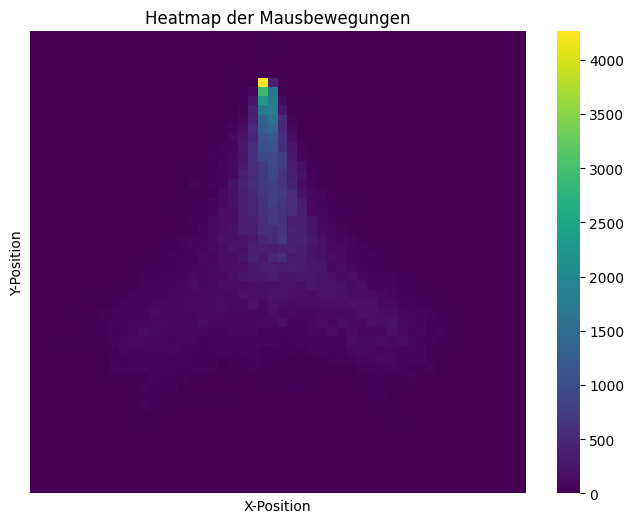

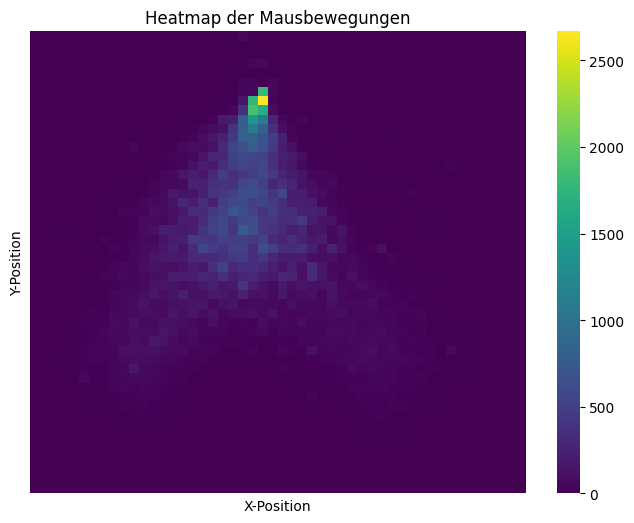

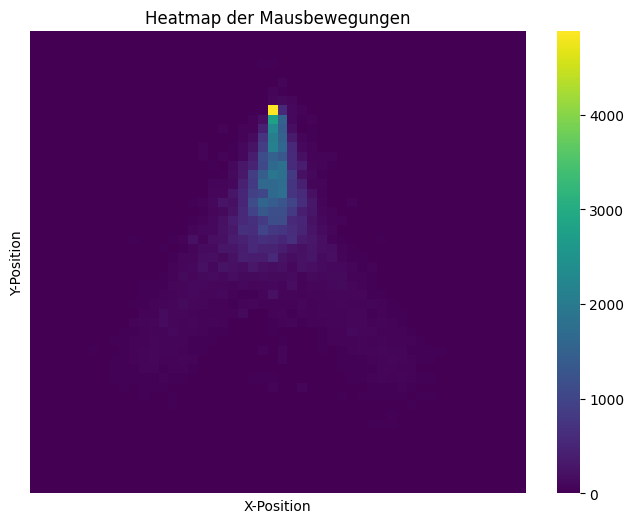

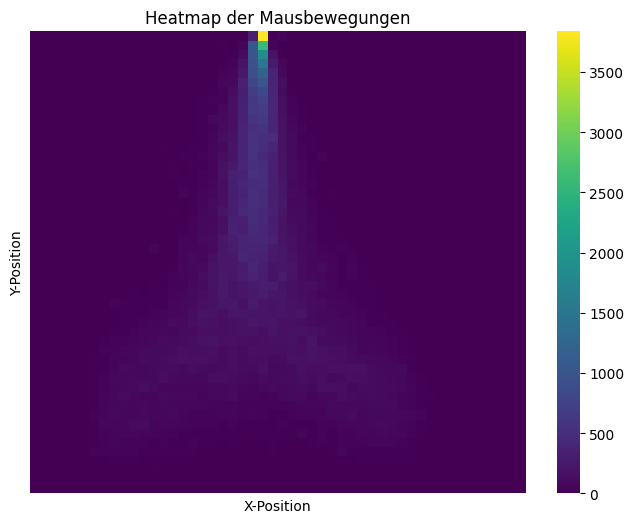

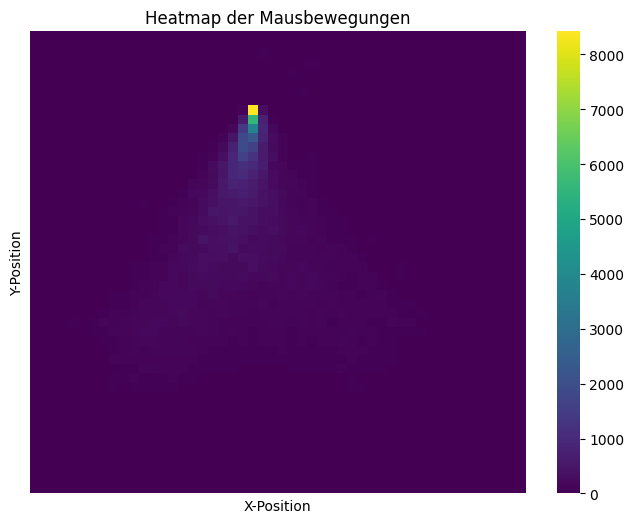

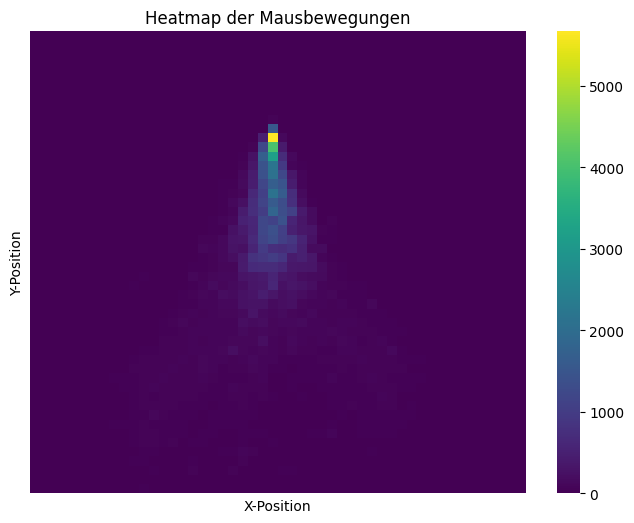

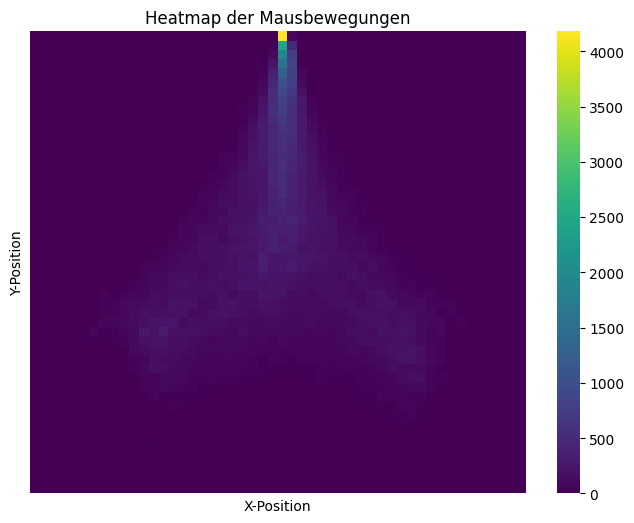

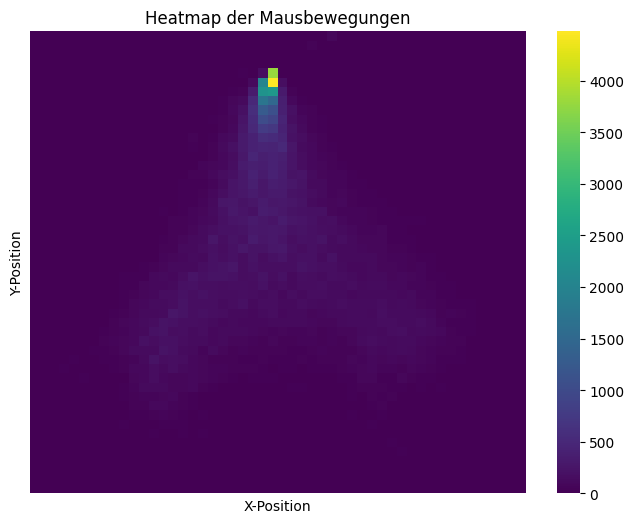

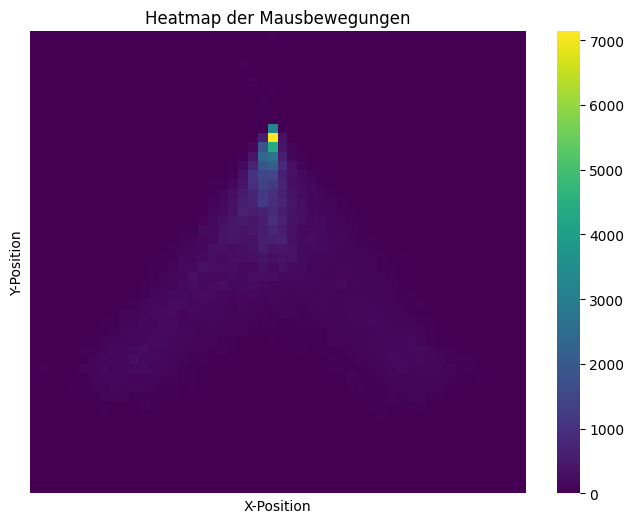

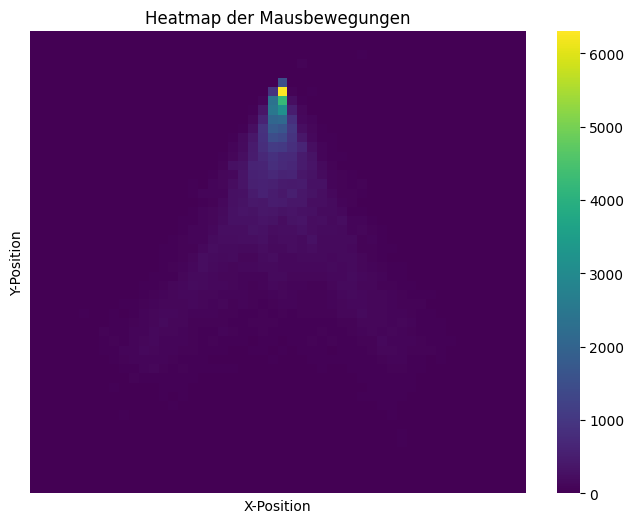

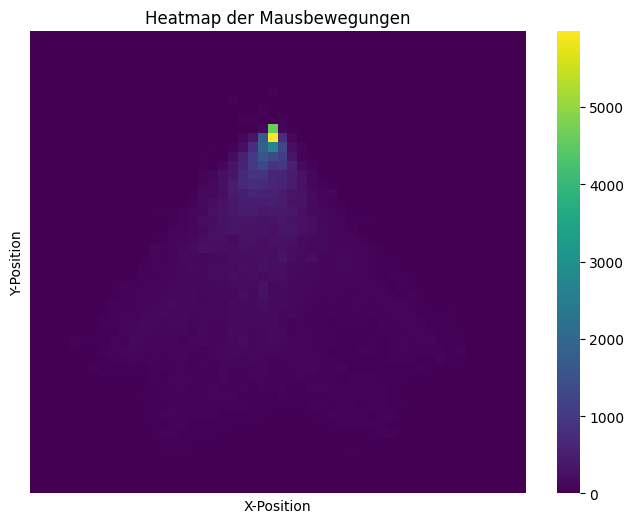

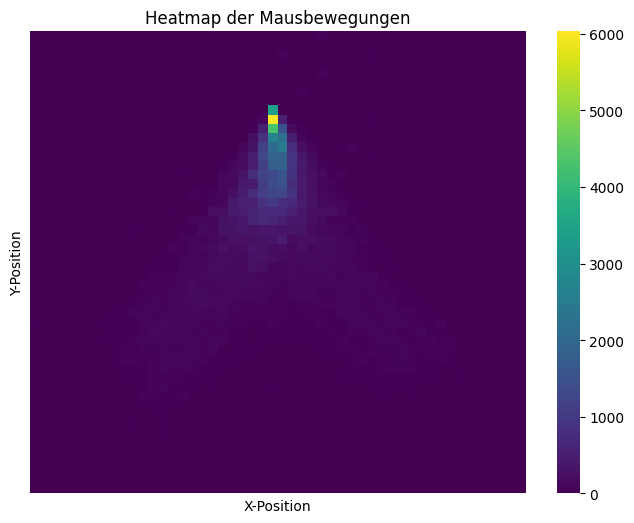

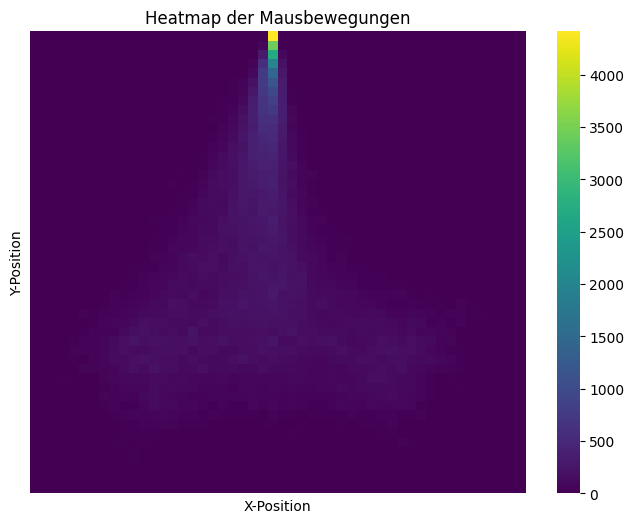

In [80]:
for grouped_mouse_data in grouped_data:
    all_xpos = [x for trial in grouped_mouse_data["xpos"] for x in trial]
    all_ypos = [y for trial in grouped_mouse_data["ypos"] for y in trial]

    # 2D-Histogramm erstellen (Heatmap-Daten)
    heatmap_data, x_edges, y_edges = np.histogram2d(
        all_xpos, all_ypos, bins=50  # 50x50 Raster
    )

    # Heatmap darstellen
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_data.T,  # Transponieren, da np.histogram2d die Achsen vertauscht
        cmap="viridis",  # Farbpalette (z. B. 'viridis', 'plasma', 'coolwarm')
        xticklabels=False, yticklabels=False  # Achsenbeschriftung entfernen
    )
    plt.title("Heatmap der Mausbewegungen")
    plt.xlabel("X-Position")
    plt.ylabel("Y-Position")
    plt.show()

In [81]:
condition_0_participants = [1, 6, 2, 4, 9, 11, 13] 


condition_0_data_mouse = []
condition_1_data_mouse = []

for grouped_mouse_data in grouped_data:
    if grouped_mouse_data['participant_num'].iloc[0] in condition_0_participants:
        condition_0_data_mouse.append(grouped_mouse_data)
    else:
        condition_1_data_mouse.append(grouped_mouse_data)
print(len(condition_0_data_mouse)) # sind 8 weil der 6er ja zweimal da is
print(len(condition_1_data_mouse))

condition_0_data_mouse

7
6


[      blocknumber  trialnumber  \
 0               1            4   
 1               1            5   
 2               1            6   
 3               1            7   
 4               1            8   
 ...           ...          ...   
 1243            4          316   
 1244            4          317   
 1245            4          318   
 1246            4          319   
 1247            4          320   
 
                                          timedifference  \
 0     [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
 1     [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
 2     [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
 3     [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
 4     [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
 ...                                                 ...   
 1243  [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
 1244  [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
 1245  [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

In [82]:
directory = "data"

trial_data_regex = r"trial_data_(\d+)"

all_trial_data = []

for filename in os.listdir(directory):
    trial_data_match = re.search(trial_data_regex, filename)

    if trial_data_match:
        participant_num = int(trial_data_match.group(1))
        file_path = os.path.join(directory, filename)

        df_trial_data = pd.read_csv(file_path, sep=",")

        df_trial_data["participant_num"] = participant_num

        all_trial_data.append(df_trial_data)
        # print(all_trial_data)

In [83]:
condition_0_participants = [1, 6, 2, 4, 9, 11, 13] 

condition_0_data_trial = []
condition_1_data_trial = []

for df in all_trial_data:
    participant_num = df["participant_num"].iloc[0]
    
    if participant_num in condition_0_participants:
        condition_0_data_trial.append(df)
    else:
        condition_1_data_trial.append(df)

print(condition_0_data_trial)
print(len(condition_1_data_trial))

[      trialnumber  blocknumber  success  reactiontime  currentcongruency  \
0               1            1        0             0                  0   
1               2            1        0             0                  1   
2               3            1        0             0                  0   
3               4            1        1           462                  1   
4               5            1        1           454                  0   
...           ...          ...      ...           ...                ...   
1279          316            4        1           615                  0   
1280          317            4        1           256                  1   
1281          318            4        1           467                  1   
1282          319            4        1           283                  1   
1283          320            4        1           423                  1   

      currentdirection  currentlocation  previouscongruency  \
0                    0 

In [84]:
condition_0_with_latency = []
condition_0_no_latency = []

for trial_list in condition_0_data_trial:
    df = pd.DataFrame(trial_list)
    
    with_latency = df.loc[df["blocknumber"].isin([1, 2])].copy()
    no_latency = df.loc[df["blocknumber"].isin([3, 4])].copy()
    
    condition_0_with_latency.append(with_latency)
    condition_0_no_latency.append(no_latency)


In [85]:
condition_1_with_latency = []
condition_1_no_latency = []

for trial_list in condition_1_data_trial:
    df = pd.DataFrame(trial_list)
    
    with_latency = df.loc[df["blocknumber"].isin([3, 4])].copy()
    no_latency = df.loc[df["blocknumber"].isin([1, 2])].copy()
    
    condition_1_with_latency.append(with_latency)
    condition_1_no_latency.append(no_latency)

In [86]:
# Wieder zusammengefügt und nach latenz condition gesplittet!
combined_trial_data_with_latency = condition_0_with_latency + condition_1_with_latency
combined_trial_data_no_latency = condition_0_no_latency + condition_1_no_latency

In [87]:
len(combined_trial_data_with_latency[0])

642

In [88]:
condition_0_with_latency_mouse = []
condition_0_no_latency_mouse = []

for mouse_df in condition_0_data_mouse:  
    with_latency = mouse_df.loc[mouse_df["blocknumber"].isin([1, 2])].copy()
    no_latency = mouse_df.loc[mouse_df["blocknumber"].isin([3, 4])].copy()
    
    condition_0_with_latency_mouse.append(with_latency)
    condition_0_no_latency_mouse.append(no_latency)


condition_1_with_latency_mouse = []
condition_1_no_latency_mouse = []

for mouse_df in condition_1_data_mouse:  
    with_latency = mouse_df.loc[mouse_df["blocknumber"].isin([3, 4])].copy()
    no_latency = mouse_df.loc[mouse_df["blocknumber"].isin([1, 2])].copy()
    
    condition_1_with_latency_mouse.append(with_latency)
    condition_1_no_latency_mouse.append(no_latency)

combined_with_latency_mouse = condition_0_with_latency_mouse + condition_1_with_latency_mouse
combined_no_latency_mouse = condition_0_no_latency_mouse + condition_1_no_latency_mouse

In [89]:
print(combined_no_latency_mouse[0])

      blocknumber  trialnumber  \
608             3            1   
609             3            2   
610             3            3   
611             3            4   
612             3            5   
...           ...          ...   
1243            4          316   
1244            4          317   
1245            4          318   
1246            4          319   
1247            4          320   

                                         timedifference  \
608   [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
609   [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
610   [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
611   [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
612   [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
...                                                 ...   
1243  [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
1244  [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
1245  [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
1

In [90]:
combined_with_latency_df = pd.concat(combined_trial_data_with_latency, ignore_index=True)
combined_with_latency_mouse_df = pd.concat(combined_with_latency_mouse, ignore_index=True)

combined_with_latency_final = pd.merge(
    combined_with_latency_df,       
    combined_with_latency_mouse_df,
    on=["trialnumber", "blocknumber", "participant_num"],
    how="inner"                      
)

print(combined_with_latency_final.columns)

Index(['trialnumber', 'blocknumber', 'success', 'reactiontime',
       'currentcongruency', 'currentdirection', 'currentlocation',
       'previouscongruency', 'previousdirection', 'previouslocation',
       'participant_num', 'timedifference', 'xpos', 'ypos'],
      dtype='object')


In [91]:
print(combined_with_latency_final.iloc[0])

trialnumber                                                           4
blocknumber                                                           1
success                                                               1
reactiontime                                                        462
currentcongruency                                                     1
currentdirection                                                      1
currentlocation                                                       0
previouscongruency                                                    0
previousdirection                                                     0
previouslocation                                                      0
participant_num                                                       1
timedifference        [0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...
xpos                  [0.0, -1.8585858585858588, -7.151515151515152,...
ypos                  [0.0, 14.86868686868687, 36.60606060606061

In [92]:
combined_no_latency_df = pd.concat(combined_trial_data_no_latency, ignore_index=True)
combined_no_latency_mouse_df = pd.concat(combined_no_latency_mouse, ignore_index=True)

combined_no_latency_final = pd.merge(
    combined_no_latency_df,       
    combined_no_latency_mouse_df,
    on=["trialnumber", "blocknumber", "participant_num"],
    how="inner"                      
)

print(len(combined_no_latency_final))

8320


## Preprocessing

### Fehlerhafte Trials ausschließen

In [93]:
combined_with_latency_final["remove"] = combined_with_latency_final["success"] == 0
combined_with_latency_final["remove"] = combined_with_latency_final["remove"] | combined_with_latency_final["remove"].shift(1, fill_value=0)
combined_with_latency_final_errors = combined_with_latency_final[~combined_with_latency_final["remove"]].drop(columns=["remove"])

print(f"Mit Latenz: Es wurden {len(combined_with_latency_final) -  len(combined_with_latency_final_errors)} fehlerhafte Trials von insgesamt {len(combined_with_latency_final)} entfernt")

Mit Latenz: Es wurden 602 fehlerhafte Trials von insgesamt 8282 entfernt


In [94]:
combined_no_latency_final["remove"] = combined_no_latency_final["success"] == 0
combined_no_latency_final["remove"] = combined_no_latency_final["remove"] | combined_no_latency_final["remove"].shift(1, fill_value=0)
combined_no_latency_final_errors = combined_no_latency_final[~combined_no_latency_final["remove"]].drop(columns=["remove"])


print(f"Ohne Latenz: Es wurden {len(combined_no_latency_final) -  len(combined_no_latency_final_errors)} fehlerhafte Trials von insgesamt {len(combined_no_latency_final)} entfernt")

Ohne Latenz: Es wurden 459 fehlerhafte Trials von insgesamt 8320 entfernt


### Ausschluss extremer Reaktionszeiten

In [95]:
averageReactiontimeWithLatency = combined_with_latency_final_errors["reactiontime"].mean()
averageReactiontimeNoLatency = combined_no_latency_final_errors["reactiontime"].mean()

print(f"Durchschnittszeit in Trials mit Latenz: {averageReactiontimeWithLatency}")
print(f"Durchschnittszeit in Trials ohne Latenz: {averageReactiontimeNoLatency}")

Durchschnittszeit in Trials mit Latenz: 505.3203125
Durchschnittszeit in Trials ohne Latenz: 446.2062078615952


In [96]:
mean_rt_with_latency = combined_with_latency_final_errors["reactiontime"].mean()
std_rt_with_latency = combined_with_latency_final_errors["reactiontime"].std()

combined_with_latency_final_errors["outlier"] = (combined_with_latency_final_errors["reactiontime"] < mean_rt_with_latency - 4 * std_rt_with_latency) | (combined_with_latency_final_errors["reactiontime"] > mean_rt_with_latency + 4 * std_rt_with_latency)

combined_with_latency_final_outliers = combined_with_latency_final_errors[~combined_with_latency_final_errors["outlier"]].drop(columns=["outlier"])

print(f"Mit Latenz: Von {len(combined_with_latency_final_errors)} wurden {len(combined_with_latency_final_errors) - len(combined_with_latency_final_outliers)} Trials aufgrund von zu hoher Standardabweichung entfernt.")

Mit Latenz: Von 7680 wurden 60 Trials aufgrund von zu hoher Standardabweichung entfernt.


In [97]:
mean_rt_no_latency = combined_no_latency_final_errors["reactiontime"].mean()
std_rt_no_latency = combined_no_latency_final_errors["reactiontime"].std()

combined_no_latency_final_errors["outlier"] = (combined_no_latency_final_errors["reactiontime"] < mean_rt_no_latency - 4 * std_rt_no_latency) | (combined_no_latency_final_errors["reactiontime"] > mean_rt_no_latency + 4 * std_rt_no_latency)

combined_no_latency_final_outliers = combined_no_latency_final_errors[~combined_no_latency_final_errors["outlier"]].drop(columns=["outlier"])

print(f"Ohne Latenz: Von {len(combined_no_latency_final_errors)} wurden {len(combined_no_latency_final_errors) - len(combined_no_latency_final_outliers)} Trials aufgrund von zu hoher Standardabweichung entfernt.")

Ohne Latenz: Von 7861 wurden 44 Trials aufgrund von zu hoher Standardabweichung entfernt.


### Spiegeln der Daten

In [98]:
def mirror_trajectories(row):
    if row["currentdirection"] == 1:
        row["xpos"] = [-x for x in row["xpos"]]
    return row

combined_no_latency_final_preprocessed = combined_no_latency_final_outliers
combined_with_latency_final_preprocessed = combined_with_latency_final_outliers

In [99]:
combined_no_latency_final_preprocessed["reactiontime"]

0       396
1       402
2       396
3       266
4       496
       ... 
8313    460
8314    439
8315    442
8318    507
8319    448
Name: reactiontime, Length: 7817, dtype: int64

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Hier dann erste Tests (für RT)

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Krümmungsgrad-Analyse

In [100]:
# für curvature
def calculate_curvature_horizontal(xpos, ypos):
    start = np.array([xpos[0], ypos[0]])
    end = np.array([xpos[-1], ypos[-1]])
    
    # geraden
    straight_line_x = np.linspace(start[0], end[0], len(xpos))  # Normierte x werte
    straight_line_y = np.linspace(start[1], end[1], len(ypos))  # Normierte y werte. braucht man hier aber ned
    
    curvature = 0
    for x, x_line in zip(xpos, straight_line_x):
        distance = abs(x - x_line)
        curvature += distance
    
    return curvature

# Berechnung der Trajektorienlänge
def calculate_trajectory_length(xpos, ypos):
    return sum(np.sqrt((xpos[i+1] - xpos[i])**2 + (ypos[i+1] - ypos[i])**2) for i in range(len(xpos)-1))


def visualize_trajectories(df):
    plt.figure(figsize=(10, 8))

    for index, row in df.iterrows():
        xpos = row['xpos']
        ypos = row['ypos']
        
        start = [xpos[0], ypos[0]]
        end = [xpos[-1], ypos[-1]]
        
        straight_line_x = np.linspace(start[0], end[0], len(xpos))
        straight_line_y = np.linspace(start[1], end[1], len(ypos))
        
        plt.plot(straight_line_x, straight_line_y, linestyle='--', alpha=0.5, label=f'Trial {index+1}' if index < 5 else "")

    plt.title("Geradenlinien der Trajektorien")
    plt.xlabel("X-Position")
    plt.ylabel("Y-Position")
    plt.legend(loc='upper right', fontsize='small', ncol=2, frameon=False)
    plt.grid(alpha=0.3)
    plt.show()



#### Ohne Latenz

In [101]:
combined_no_latency_final_preprocessed['curvature'] = combined_no_latency_final_preprocessed.apply(lambda row: calculate_curvature_horizontal(row['xpos'], row['ypos']), axis=1)


combined_no_latency_final_preprocessed['trajectory_length'] = combined_no_latency_final_preprocessed.apply(lambda row: calculate_trajectory_length(row['xpos'], row['ypos']), axis=1)
combined_no_latency_final_preprocessed['normalized_curvature'] = combined_no_latency_final_preprocessed['curvature'] / combined_no_latency_final_preprocessed['trajectory_length']

min_curvature = combined_no_latency_final_preprocessed['normalized_curvature'].min()
max_curvature = combined_no_latency_final_preprocessed['normalized_curvature'].max()

combined_no_latency_final_preprocessed['normalized_curvature_minmax'] = (combined_no_latency_final_preprocessed['normalized_curvature'] - min_curvature) / (max_curvature - min_curvature)

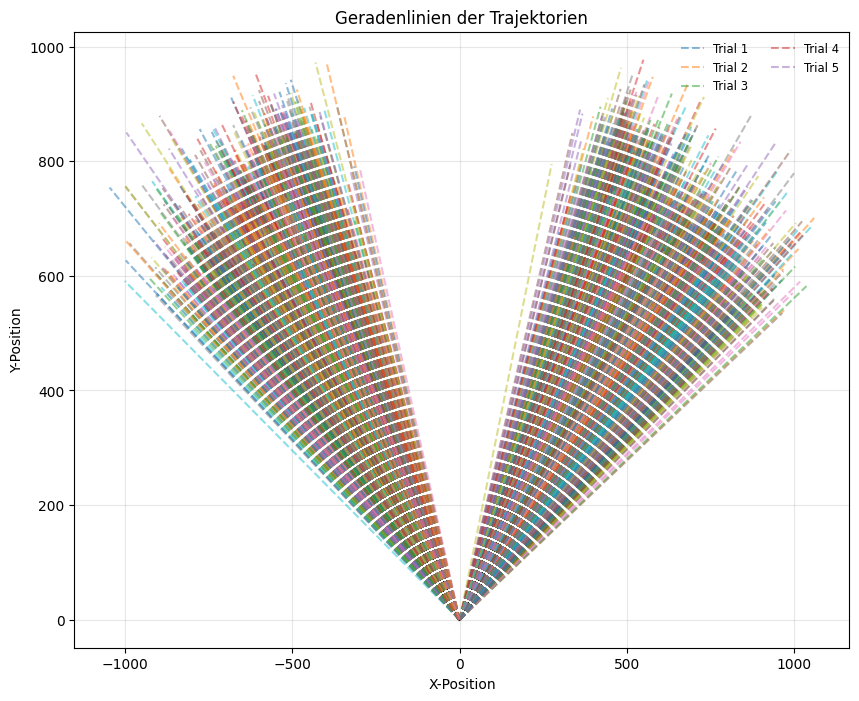

In [102]:
visualize_trajectories(combined_no_latency_final_preprocessed)

In [103]:
combined_with_latency_final_preprocessed['curvature'] = combined_with_latency_final_preprocessed.apply(lambda row: calculate_curvature_horizontal(row['xpos'], row['ypos']), axis=1)


combined_with_latency_final_preprocessed['trajectory_length'] = combined_with_latency_final_preprocessed.apply(lambda row: calculate_trajectory_length(row['xpos'], row['ypos']), axis=1)
combined_with_latency_final_preprocessed['normalized_curvature'] = combined_with_latency_final_preprocessed['curvature'] / combined_with_latency_final_preprocessed['trajectory_length']

min_curvature = combined_with_latency_final_preprocessed['normalized_curvature'].min()
max_curvature = combined_with_latency_final_preprocessed['normalized_curvature'].max()

combined_with_latency_final_preprocessed['normalized_curvature_minmax'] = (combined_with_latency_final_preprocessed['normalized_curvature'] - min_curvature) / (max_curvature - min_curvature)

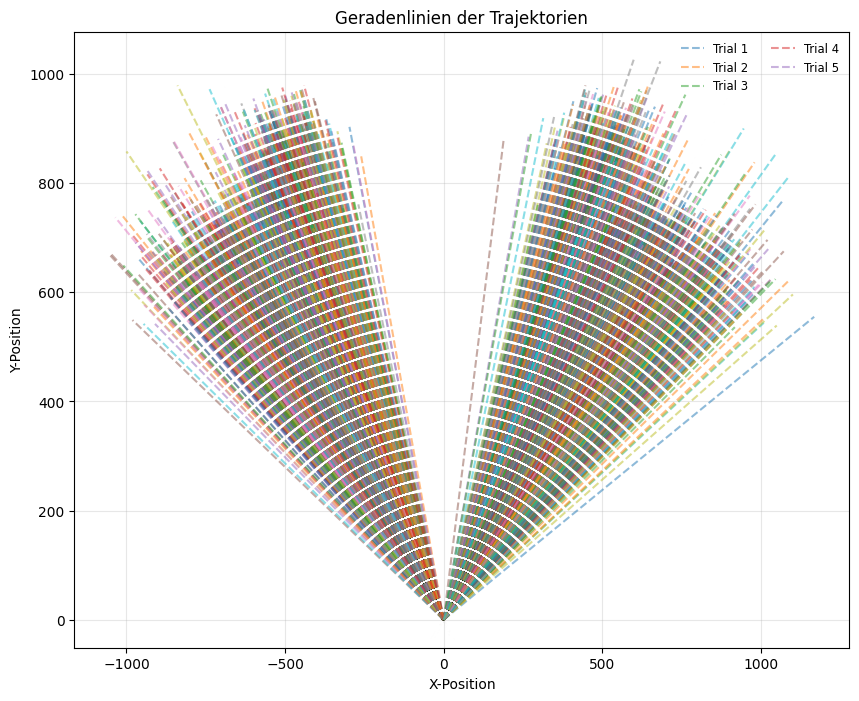

In [104]:
visualize_trajectories(combined_with_latency_final_preprocessed)

### Jedem Trial ein "slow_trial" hinzufügen, welches anhand der median RT gegeben wird. (Langsamer Trial = 1; Schneller Trial = 0)

In [105]:
combined_no_latency_final_preprocessed["reactiontime"] = pd.to_numeric(combined_no_latency_final_preprocessed["reactiontime"])
combined_no_latency_final_preprocessed["median_rt"] = combined_no_latency_final_preprocessed.groupby("participant_num")["reactiontime"].transform("median")
combined_no_latency_final_preprocessed["slow_trial"] = (combined_no_latency_final_preprocessed["reactiontime"] > combined_no_latency_final_preprocessed["median_rt"]).astype(int)

combined_with_latency_final_preprocessed["reactiontime"] = pd.to_numeric(combined_with_latency_final_preprocessed["reactiontime"])
combined_with_latency_final_preprocessed["median_rt"] = combined_with_latency_final_preprocessed.groupby("participant_num")["reactiontime"].transform("median")
combined_with_latency_final_preprocessed["slow_trial"] = (combined_with_latency_final_preprocessed["reactiontime"] > combined_with_latency_final_preprocessed["median_rt"]).astype(int)

combined_no_latency_final_preprocessed.head()

,trialnumber,blocknumber,success,reactiontime,currentcongruency,currentdirection,currentlocation,previouscongruency,previousdirection,previouslocation,participant_num,timedifference,xpos,ypos,curvature,trajectory_length,normalized_curvature,normalized_curvature_minmax,median_rt,slow_trial
0,1,3,1,396,1,1,0,1,1,0,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, -0.38383838383838426, -1....","[0.0, 11.171717171717173, 22.343434343434346, ...",25230.707071,1253.513624,20.127988,0.537479,400.0,0
1,2,3,1,402,0,0,1,1,1,0,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 6.464646464646465, 14.161616161616163, 2...","[0.0, 4.040404040404041, 9.92929292929293, 16....",33860.272727,1368.411512,24.744218,0.665961,400.0,1
2,3,3,1,396,1,0,1,0,0,1,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 1.595959595959596, 3.191919191919192, 4....","[0.0, 5.5858585858585865, 12.363636363636365, ...",29520.818182,1526.851628,19.334438,0.515393,400.0,0
3,4,3,1,266,0,0,0,1,0,1,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -1.0707070707070707, -2.141414141414142,...","[0.0, 2.676767676767677, 5.636363636363638, 10...",15266.888889,835.405529,18.274824,0.485901,400.0,0
4,5,3,1,496,0,1,1,0,0,0,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -2.0, -2.0, -4.0, -4.0, -5.0, -5.0, -7.0...","[0.0, 1.0, 4.0, 5.0, 8.0, 9.0, 12.0, 13.0, 15....",13961.000000,1278.320206,10.921364,0.281236,400.0,1


#### 4 Prädikatoren

direction(n) = **currentdirection** (1 = right; 0 = left) </br>
location(n) = **currentlocation** (1 = right; 0 = left) </br>
response(n - 1) = reflects previous (correct) response and hence the **previousdirection** (1 = right; 0 = left) </br>
congruency(n - 1) reflects the expected influence of the direction(n - 1)/location(n - 1), **previouscongruency** (1 = congruent, 0 = incongruent) 

In [106]:
def compute_trajectory_angles(xpos, ypos):
    if len(xpos) < 2 or len(ypos) < 2:
        return np.nan  
    
    x_array = np.array(xpos)
    y_array = np.array(ypos)

    delta_x = np.diff(x_array)  
    delta_y = np.diff(y_array)  
    
    # Compute angles relative to Y-axis
    angles_rad = np.arctan2(delta_x, delta_y)  
    
    # Normalize angles between -1 and 1
    angles_normalized = angles_rad / np.pi
    
    return angles_normalized.tolist()  

Umwandeln von 0ern der Prädikatoren in -1 Werte

In [107]:
predictor_columns = ["currentdirection", "currentlocation", "previousdirection", "previouscongruency"]

combined_no_latency_final_preprocessed[predictor_columns] = combined_no_latency_final_preprocessed[predictor_columns].replace(0, -1)
combined_with_latency_final_preprocessed[predictor_columns] = combined_with_latency_final_preprocessed[predictor_columns].replace(0, -1)

combined_no_latency_final_preprocessed.head()

,trialnumber,blocknumber,success,reactiontime,currentcongruency,currentdirection,currentlocation,previouscongruency,previousdirection,previouslocation,participant_num,timedifference,xpos,ypos,curvature,trajectory_length,normalized_curvature,normalized_curvature_minmax,median_rt,slow_trial
0,1,3,1,396,1,1,-1,1,1,0,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, -0.38383838383838426, -1....","[0.0, 11.171717171717173, 22.343434343434346, ...",25230.707071,1253.513624,20.127988,0.537479,400.0,0
1,2,3,1,402,0,-1,1,1,1,0,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 6.464646464646465, 14.161616161616163, 2...","[0.0, 4.040404040404041, 9.92929292929293, 16....",33860.272727,1368.411512,24.744218,0.665961,400.0,1
2,3,3,1,396,1,-1,1,-1,-1,1,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 1.595959595959596, 3.191919191919192, 4....","[0.0, 5.5858585858585865, 12.363636363636365, ...",29520.818182,1526.851628,19.334438,0.515393,400.0,0
3,4,3,1,266,0,-1,-1,1,-1,1,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -1.0707070707070707, -2.141414141414142,...","[0.0, 2.676767676767677, 5.636363636363638, 10...",15266.888889,835.405529,18.274824,0.485901,400.0,0
4,5,3,1,496,0,1,1,-1,-1,0,1,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -2.0, -2.0, -4.0, -4.0, -5.0, -5.0, -7.0...","[0.0, 1.0, 4.0, 5.0, 8.0, 9.0, 12.0, 13.0, 15....",13961.000000,1278.320206,10.921364,0.281236,400.0,1


#### Berechnen der Trajectory Angles (100 Zeitschritte)

In [108]:
combined_no_latency_final_preprocessed["trajectory_angle"] = combined_no_latency_final_preprocessed.apply(lambda row: compute_trajectory_angles(row["xpos"], row["ypos"]), axis=1)
combined_with_latency_final_preprocessed["trajectory_angle"] = combined_with_latency_final_preprocessed.apply(lambda row: compute_trajectory_angles(row["xpos"], row["ypos"]), axis=1)

print(combined_no_latency_final_preprocessed["trajectory_angle"].iloc[0]) 
print(combined_with_latency_final_preprocessed["trajectory_angle"].iloc[0]) 

[0.0, 0.0, 0.0, -0.011958540456714366, -0.06960448727306393, -0.06298636053191246, -0.01980971959788098, -0.11454548957280279, -0.25939882537924736, 0.0, -0.2380689698427858, -0.09742520095620845, -0.1596655293982666, -0.2389834881151767, -0.20483276469913356, -0.10834693614812307, -0.18388561284073984, -0.20997787377357782, -0.21984390452160765, -0.2499999999999993, -0.2500000000000007, -0.22666798624647247, -0.231688244596965, -0.2570515025248739, -0.2788579383763045, -0.2545340221976979, -0.24999999999999778, 0.0, 0.0, 0.0, 0.23744165604921483, 0.36718542570760054, 0.3571943473983582, 0.3241555954522046, 0.3055998877857848, 0.23219881787003982, 0.24067111170153946, 0.1807680226635889, 0.009382339984868822, 0.0525684567112535, 0.007668633741357628, 0.0, -0.05885313502045133, -0.12722793095810522, -0.09277357907774236, -0.15257745622457583, -0.13858919622156252, -0.13670356894997035, -0.1496240376912004, -0.16524934053856805, -0.13652782806909744, -0.16039201831743957, -0.171453725659

#### Berechnen der Beta-Gewichte und Grand averages

In [129]:
def get_beta_weights_per_participant(df):
    x = df[predictor_columns].values
    x = sm.add_constant(x)

    participant_ids = df["participant_num"].unique()
    beta_weights_per_participant = {p_id: np.zeros((4, 100)) for p_id in participant_ids}

    for participant in participant_ids:
        participant_trials = df[df["participant_num"] == participant]
        traj_matrix = np.array(participant_trials["trajectory_angle"].tolist())

        x_participant = participant_trials[predictor_columns].values
        x_participant = sm.add_constant(x_participant)

        for t in range(99):
            y = traj_matrix[:, t]

            if y.shape[0] < 2:
                continue

            model = sm.OLS(y, x_participant).fit()
            beta_weights_per_participant[participant][:, t] = model.params[1:]

    return beta_weights_per_participant
    
def trajectory_angle_multiple_regression_part(df):
    beta_weights_per_participant = get_beta_weights_per_participant(df)
    
    beta_avg = np.mean(np.array(list(beta_weights_per_participant.values())), axis = 0)

    beta_df = pd.DataFrame(beta_avg.T, columns=predictor_columns)

    return beta_df

In [133]:
beta_weights_per_participant_with_latency = get_beta_weights_per_participant(combined_with_latency_final_preprocessed)
beta_weights_per_participant_no_latency = get_beta_weights_per_participant(combined_no_latency_final_preprocessed)

beta_weights_with_latency = trajectory_angle_multiple_regression_part(combined_with_latency_final_preprocessed)
beta_weights_no_latency = trajectory_angle_multiple_regression_part(combined_no_latency_final_preprocessed)

beta_weights_with_latency.head()

,currentdirection,currentlocation,previousdirection,previouscongruency
0,0.001567,-0.003271,0.006147,0.002151
1,0.001777,-0.002379,0.003567,0.000513
2,0.000146,-0.002418,0.002611,0.000720
3,0.000717,-0.002599,0.003589,0.001283
4,0.001592,-0.002345,0.004053,0.001077


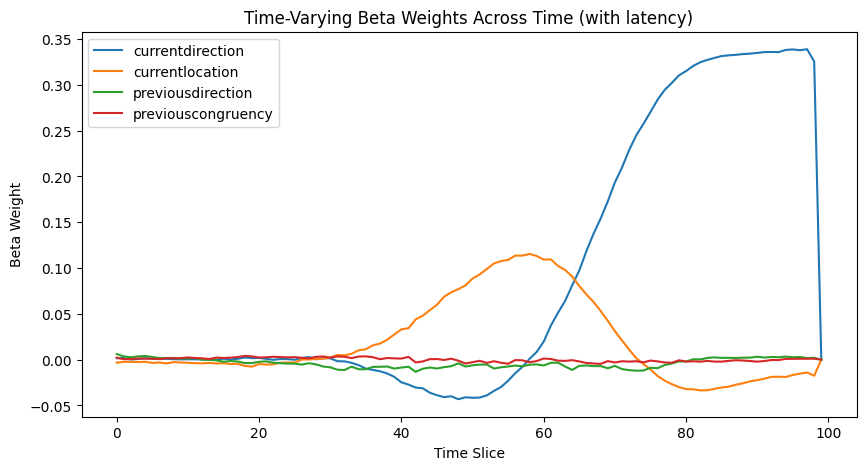

In [134]:
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(beta_weights_with_latency.index, beta_weights_with_latency.iloc[:, i], label=f"{predictor_columns[i]}")

plt.xlabel("Time Slice")
plt.ylabel("Beta Weight")
plt.legend()
plt.title("Time-Varying Beta Weights Across Time (with latency)")
plt.show()


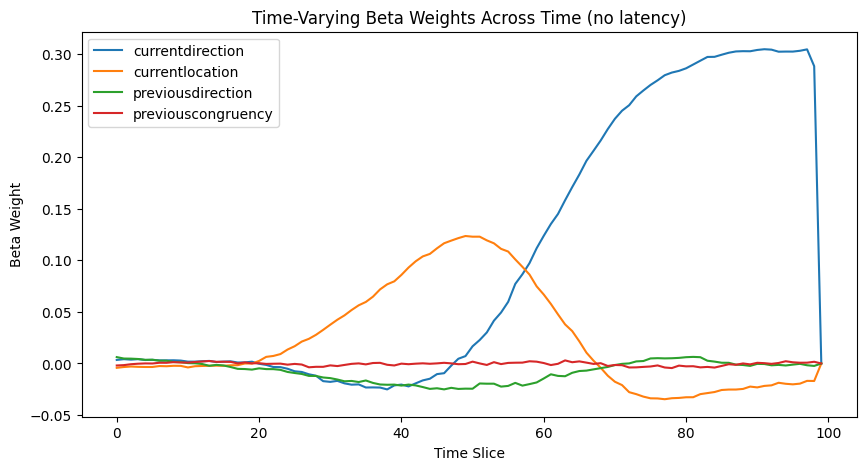

In [135]:
plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(beta_weights_no_latency.index, beta_weights_no_latency.iloc[:, i], label=f"{predictor_columns[i]}")

plt.xlabel("Time Slice")
plt.ylabel("Beta Weight")
plt.legend()
plt.title("Time-Varying Beta Weights Across Time (no latency)")
plt.show()


In [136]:
    beta_weights_wl = beta_weights_with_latency.to_numpy()

    peak_beta_values_with_latency = np.max(np.abs(beta_weights_wl), axis = 0)
    peak_beta_indices_with_latency = np.argmax(np.abs(beta_weights_wl), axis = 0)

    print(peak_beta_values_with_latency)
    print(peak_beta_indices_with_latency)

[0.33892831 0.11543507 0.01323454 0.00460424]
[97 58 42 68]


In [137]:
    beta_weights_nl = beta_weights_no_latency.to_numpy()

    peak_beta_values_no_latency = np.max(np.abs(beta_weights_nl), axis = 0)
    peak_beta_indices_no_latency = np.argmax(np.abs(beta_weights_nl), axis = 0)

    print(peak_beta_values_no_latency)
    print(peak_beta_indices_no_latency)

[0.30469436 0.12358997 0.02510452 0.00444551]
[91 49 46 78]


#### one sample t-tests of peak beta weights against zero

In [142]:
beta_per_participant_with_latency = np.array(list(beta_weights_per_participant_with_latency.values())) 

peak_beta_per_participant_with_latency = np.max(np.abs(beta_per_participant_with_latency), axis=2) 

for i, predictor in enumerate(predictor_columns):
    t_stat, p_value = ttest_1samp(beta_per_participant_with_latency[:, i], 0)
    print(f"{predictor} Peak Beta t-test: t={t_stat:.3f}, p={p_value:.5f}")

TypeError: unsupported format string passed to numpy.ndarray.__format__

#### paired t-tests for peak timing differences

In [143]:
peak_indices_per_participant_with_latency = np.argmax(np.abs(beta_per_participant_with_latency), axis=2) 

# Perform paired t-tests between predictors' peak times
for i in range(4):
    for j in range(i+1, 4):
        t_stat, p_value = ttest_rel(peak_indices_per_participant_with_latency[:, i], peak_indices_per_participant_with_latency[:, j])
        print(f"Paired t-test: {i+1} vs {j+1}: t={t_stat:.3f}, p={p_value:.5f}")


Paired t-test: 1 vs 2: t=7.919, p=0.00000
Paired t-test: 1 vs 3: t=7.657, p=0.00001
Paired t-test: 1 vs 4: t=7.188, p=0.00001
Paired t-test: 2 vs 3: t=4.293, p=0.00104
Paired t-test: 2 vs 4: t=0.427, p=0.67711
Paired t-test: 3 vs 4: t=-4.058, p=0.00159


In [144]:
num_participants = beta_per_participant_with_latency.shape[0]
jackknife_t_values = []

for leave_out in range(num_participants):
    # Create jackknife sample (leave one participant out)
    jackknife_sample = np.delete(beta_per_participant_with_latency, leave_out, axis=0)
    
    # Compute grand-average beta weights after leaving one out
    jackknife_avg = np.mean(jackknife_sample, axis=0)
    
    # Extract peak beta weights
    peak_jackknife = np.max(np.abs(jackknife_avg), axis=1)
    
    # Perform t-tests
    t_values = [ttest_1samp(peak_jackknife[i], 0)[0] for i in range(4)]
    jackknife_t_values.append(t_values)

# Convert jackknife t-values to array for further analysis
jackknife_t_values = np.array(jackknife_t_values)

# Compute jackknife estimate of standard error
jackknife_std_error = np.sqrt((num_participants - 1) * np.var(jackknife_t_values, axis=0))

print("Jackknife-adjusted standard errors:", jackknife_std_error)


Jackknife-adjusted standard errors: [nan nan nan nan]


c:\Users\Matthias\Documents\GitHub\continuousSimonTask\venv\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
c:\Users\Matthias\Documents\GitHub\continuousSimonTask\venv\lib\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


In [115]:
def tracectory_angle_multiple_regressions(df):
    trajectory_matrix = np.array(df["trajectory_angle"].tolist())  # Shape: (50 trials, 100 time slices)

    # Extract predictor values (X matrix, shape: 50 trials x 4 predictors)
    X = df[predictor_columns].values

    # Add constant term for intercept
    X = sm.add_constant(X)  # Shape: (50 trials, 5 predictors including intercept)

    # Initialize array to store beta weights (4 predictors across 100 time slices)
    beta_weights = np.zeros((4, 100))  # Shape: (4 predictors, 100 time slices)

    # Perform regression for each time slice
    for t in range(100):  
        y = trajectory_matrix[:, t]  # Extract trajectory angle at time slice t (Shape: 50 trials)
        
        model = sm.OLS(y, X).fit()  # Fit multiple regression model
        beta_weights[:, t] = model.params[1:]  # Exclude intercept and store 4 beta values

    # Convert beta weights to DataFrame for better visualization
    beta_df = pd.DataFrame(beta_weights.T, columns=["beta1", "beta2", "beta3", "beta4"])
    
    return beta_df


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [116]:
df_trial_data = pd.read_csv("data/trial_data.txt", sep=",")
df_trial_data

,trialnumber,blocknumber,success,reactiontime,currentcongruency,currentdirection,currentlocation,previouscongruency,previousdirection,previouslocation
0,1,1,1,1307,0,1,1,0,1,1
1,2,1,1,1747,1,0,0,0,1,1
2,3,1,1,1473,1,1,1,1,0,0
3,4,1,1,1350,0,1,1,1,1,1
4,5,1,1,2279,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
291,291,1,0,0,0,0,1,0,0,0
292,292,1,0,0,1,1,1,0,0,1
293,293,1,0,0,0,1,0,1,1,1
294,294,1,0,0,0,1,0,0,1,0


In [117]:
merged_df = pd.merge(grouped_mouse_data, df_trial_data, on="trialnumber", how="inner")
merged_df

,blocknumber_x,trialnumber,timedifference,xpos,ypos,participant_num,blocknumber_y,success,reactiontime,currentcongruency,currentdirection,currentlocation,previouscongruency,previousdirection,previouslocation
0,1,7,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -1.777777777777778, -3.555555555555556, ...","[0.0, 4.444444444444445, 9.666666666666668, 15...",9,1,1,1736,1,1,0,0,1,1
1,1,8,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.4848484848484863, ...","[0.0, 4.242424242424243, 9.878787878787879, 15...",9,1,1,1190,1,1,1,1,1,0
2,1,9,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.060606060606...","[0.0, 10.545454545454547, 21.77777777777778, 3...",9,1,1,1862,1,1,1,1,1,1
3,1,10,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -0.1818181818181821, -2.181818181818182,...","[0.0, 3.181818181818182, 5.545454545454547, 9....",9,1,1,1250,0,1,1,1,1,1
4,1,11,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 6.484848484848484, 15.09090909090909, 24...",9,1,1,1895,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,4,291,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -4.505050505050505, -10.212121212121213,...","[0.0, 8.212121212121213, 21.02020202020202, 32...",9,1,0,0,0,0,1,0,0,0
1173,4,292,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, -0.9090909090909093, -1.878787...","[0.0, 2.909090909090909, 5.818181818181818, 9....",9,1,0,0,1,1,1,0,0,1
1174,4,293,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -1.6565656565656568, -3.9696969696969697...","[0.0, 4.141414141414142, 9.595959595959597, 15...",9,1,0,0,0,1,0,1,1,1
1175,4,294,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -1.0505050505050506, -2.101010101010101,...","[0.0, 4.7272727272727275, 9.353535353535353, 1...",9,1,0,0,0,1,0,0,1,0


In [118]:
# Fails entfernen
merged_df["remove"] = merged_df["success"] == 0
merged_df["remove"] = merged_df["remove"] | merged_df["remove"].shift(1, fill_value=0)
filtered_df = merged_df[~merged_df["remove"]].drop(columns=["remove"])
filtered_df

,blocknumber_x,trialnumber,timedifference,xpos,ypos,participant_num,blocknumber_y,success,reactiontime,currentcongruency,currentdirection,currentlocation,previouscongruency,previousdirection,previouslocation
0,1,7,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -1.777777777777778, -3.555555555555556, ...","[0.0, 4.444444444444445, 9.666666666666668, 15...",9,1,1,1736,1,1,0,0,1,1
1,1,8,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.4848484848484863, ...","[0.0, 4.242424242424243, 9.878787878787879, 15...",9,1,1,1190,1,1,1,1,1,0
2,1,9,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.060606060606...","[0.0, 10.545454545454547, 21.77777777777778, 3...",9,1,1,1862,1,1,1,1,1,1
3,1,10,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -0.1818181818181821, -2.181818181818182,...","[0.0, 3.181818181818182, 5.545454545454547, 9....",9,1,1,1250,0,1,1,1,1,1
4,1,11,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 6.484848484848484, 15.09090909090909, 24...",9,1,1,1895,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,4,262,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.7878787878787881, 2.3636363636363...","[0.0, 6.272727272727273, 13.727272727272728, 2...",9,1,1,1236,0,1,0,0,0,0
1144,4,263,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 1.3131313131313131, 2.0, 2.0, 2.0, 2.0, ...","[0.0, 4.595959595959596, 10.131313131313131, 1...",9,1,1,1246,1,0,1,0,1,0
1145,4,264,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.6262626262626264, 1.9393939393939...","[0.0, 4.595959595959596, 8.878787878787879, 12...",9,1,1,1140,0,0,0,1,0,1
1153,4,272,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.6666666666666667, 1.666666666666667, 3...",9,1,1,1956,1,0,0,1,1,1


In [119]:
# Standartabweichung > +-4 entfernen
mean_rt = filtered_df["reactiontime"].mean()
std_rt = filtered_df["reactiontime"].std()

filtered_df["outlier"] = (filtered_df["reactiontime"] < mean_rt - 4 * std_rt) | (filtered_df["reactiontime"] > mean_rt + 4 * std_rt)

filtered_df_new = filtered_df[~filtered_df["outlier"]].drop(columns=["outlier"])
filtered_df_new

,blocknumber_x,trialnumber,timedifference,xpos,ypos,participant_num,blocknumber_y,success,reactiontime,currentcongruency,currentdirection,currentlocation,previouscongruency,previousdirection,previouslocation
0,1,7,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -1.777777777777778, -3.555555555555556, ...","[0.0, 4.444444444444445, 9.666666666666668, 15...",9,1,1,1736,1,1,0,0,1,1
1,1,8,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.4848484848484863, ...","[0.0, 4.242424242424243, 9.878787878787879, 15...",9,1,1,1190,1,1,1,1,1,0
2,1,9,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.060606060606...","[0.0, 10.545454545454547, 21.77777777777778, 3...",9,1,1,1862,1,1,1,1,1,1
3,1,10,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, -0.1818181818181821, -2.181818181818182,...","[0.0, 3.181818181818182, 5.545454545454547, 9....",9,1,1,1250,0,1,1,1,1,1
4,1,11,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 6.484848484848484, 15.09090909090909, 24...",9,1,1,1895,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,4,262,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.7878787878787881, 2.3636363636363...","[0.0, 6.272727272727273, 13.727272727272728, 2...",9,1,1,1236,0,1,0,0,0,0
1144,4,263,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 1.3131313131313131, 2.0, 2.0, 2.0, 2.0, ...","[0.0, 4.595959595959596, 10.131313131313131, 1...",9,1,1,1246,1,0,1,0,1,0
1145,4,264,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.6262626262626264, 1.9393939393939...","[0.0, 4.595959595959596, 8.878787878787879, 12...",9,1,1,1140,0,0,0,1,0,1
1153,4,272,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.6666666666666667, 1.666666666666667, 3...",9,1,1,1956,1,0,0,1,1,1


In [120]:
# daten alle auf eine seite spiegeln
def mirror_trajectories(row):
    if row["currentdirection"] == 1:
        row["xpos"] = [-x for x in row["xpos"]]
    return row
mirrored_df =filtered_df_new.apply(mirror_trajectories, axis=1)

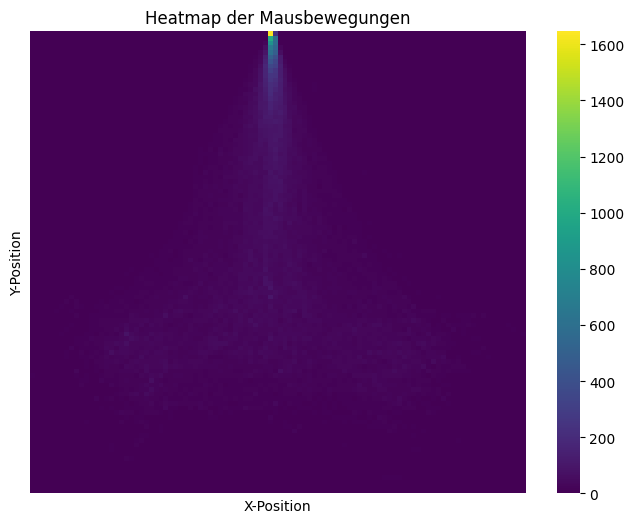

In [121]:
all_xpos = [x for trial in mirrored_df["xpos"] for x in trial]
all_ypos = [y for trial in mirrored_df["ypos"] for y in trial]

# 2D-Histogramm erstellen (Heatmap-Daten)
heatmap_data, x_edges, y_edges = np.histogram2d(
    all_xpos, all_ypos, bins=100  # 50x50 Raster
)

# Heatmap darstellen
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data.T,  # Transponieren, da np.histogram2d die Achsen vertauscht
    cmap="viridis",  # Farbpalette (z. B. 'viridis', 'plasma', 'coolwarm')
    xticklabels=False, yticklabels=False  # Achsenbeschriftung entfernen
)
plt.title("Heatmap der Mausbewegungen")
plt.xlabel("X-Position")
plt.ylabel("Y-Position")
plt.show()

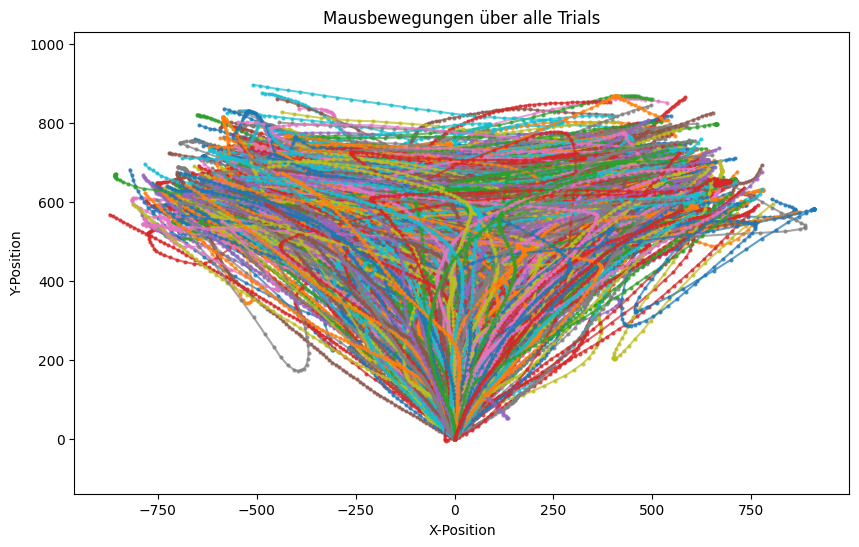

In [122]:
import matplotlib.pyplot as plt

# Plot initialisieren
plt.figure(figsize=(10, 6))

for trial_x, trial_y in zip(mirrored_df["xpos"], mirrored_df["ypos"]):
    plt.plot(trial_x, trial_y, linestyle='-', marker='o', markersize=2, alpha=0.7)

# Achsen und Titel
plt.xlabel("X-Position")
plt.ylabel("Y-Position")
plt.title("Mausbewegungen über alle Trials")
plt.axis('equal')

plt.show()


In [123]:
print(mirrored_df.iloc[0]["ypos"])

[  0.           4.44444444   9.66666667  15.66666667  23.55555556
  32.          40.          48.66666667  59.22222222  69.
  81.44444444  92.33333333 105.66666667 118.77777778 131.66666667
 144.66666667 157.55555556 171.77777778 186.         202.
 216.44444444 230.66666667 244.88888889 260.         275.33333333
 290.         305.77777778 320.         336.         352.
 366.66666667 382.         398.         413.33333333 427.55555556
 441.77777778 456.         468.44444444 482.44444444 494.
 505.77777778 516.88888889 526.33333333 535.88888889 547.22222222
 557.         563.22222222 568.66666667 576.         581.22222222
 585.66666667 590.66666667 594.88888889 598.77777778 605.
 608.55555556 612.11111111 615.         618.77777778 622.33333333
 624.33333333 625.66666667 628.33333333 631.         632.77777778
 634.55555556 635.66666667 636.55555556 637.         637.33333333
 638.         638.22222222 640.         640.         641.55555556
 642.         642.         642.         642.666666

In [124]:
# für curvature
def calculate_curvature_horizontal(xpos, ypos):
    start = np.array([xpos[0], ypos[0]])
    end = np.array([xpos[-1], ypos[-1]])
    
    # geraden
    straight_line_x = np.linspace(start[0], end[0], len(xpos))  # Normierte x werte
    straight_line_y = np.linspace(start[1], end[1], len(ypos))  # Normierte y werte. braucht man hier aber ned
    
    curvature = 0
    for x, x_line in zip(xpos, straight_line_x):
        distance = abs(x - x_line)
        curvature += distance
    
    return curvature

mirrored_df['curvature'] = mirrored_df.apply(lambda row: calculate_curvature_horizontal(row['xpos'], row['ypos']), axis=1)

mirrored_df



,blocknumber_x,trialnumber,timedifference,xpos,ypos,participant_num,blocknumber_y,success,reactiontime,currentcongruency,currentdirection,currentlocation,previouscongruency,previousdirection,previouslocation,curvature
0,1,7,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[-0.0, 1.777777777777778, 3.555555555555556, 5...","[0.0, 4.444444444444445, 9.666666666666668, 15...",9,1,1,1736,1,1,0,0,1,1,19714.777778
1,1,8,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.484848484848...","[0.0, 4.242424242424243, 9.878787878787879, 15...",9,1,1,1190,1,1,1,1,1,0,18200.181818
2,1,9,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0606060...","[0.0, 10.545454545454547, 21.77777777777778, 3...",9,1,1,1862,1,1,1,1,1,1,17921.323232
3,1,10,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[-0.0, 0.1818181818181821, 2.181818181818182, ...","[0.0, 3.181818181818182, 5.545454545454547, 9....",9,1,1,1250,0,1,1,1,1,1,26528.727273
4,1,11,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 6.484848484848484, 15.09090909090909, 24...",9,1,1,1895,0,0,1,0,1,1,17926.585859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,4,262,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[-0.0, -0.0, -0.7878787878787881, -2.363636363...","[0.0, 6.272727272727273, 13.727272727272728, 2...",9,1,1,1236,0,1,0,0,0,0,15308.606061
1144,4,263,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 1.3131313131313131, 2.0, 2.0, 2.0, 2.0, ...","[0.0, 4.595959595959596, 10.131313131313131, 1...",9,1,1,1246,1,0,1,0,1,0,11587.818182
1145,4,264,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.6262626262626264, 1.9393939393939...","[0.0, 4.595959595959596, 8.878787878787879, 12...",9,1,1,1140,0,0,0,1,0,1,9671.161616
1153,4,272,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.6666666666666667, 1.666666666666667, 3...",9,1,1,1956,1,0,0,1,1,1,14031.333333


In [125]:
# Berechnung der Trajektorienlänge
def calculate_trajectory_length(xpos, ypos):
    return sum(np.sqrt((xpos[i+1] - xpos[i])**2 + (ypos[i+1] - ypos[i])**2) for i in range(len(xpos)-1))

mirrored_df['trajectory_length'] = mirrored_df.apply(lambda row: calculate_trajectory_length(row['xpos'], row['ypos']), axis=1)
mirrored_df['normalized_curvature'] = mirrored_df['curvature'] / mirrored_df['trajectory_length']

min_curvature = mirrored_df['normalized_curvature'].min()
max_curvature = mirrored_df['normalized_curvature'].max()

mirrored_df['normalized_curvature_minmax'] = (mirrored_df['normalized_curvature'] - min_curvature) / (max_curvature - min_curvature)

mirrored_df


,blocknumber_x,trialnumber,timedifference,xpos,ypos,participant_num,blocknumber_y,success,reactiontime,currentcongruency,currentdirection,currentlocation,previouscongruency,previousdirection,previouslocation,curvature,trajectory_length,normalized_curvature,normalized_curvature_minmax
0,1,7,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[-0.0, 1.777777777777778, 3.555555555555556, 5...","[0.0, 4.444444444444445, 9.666666666666668, 15...",9,1,1,1736,1,1,0,0,1,1,19714.777778,1131.272382,17.427083,0.595352
1,1,8,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.484848484848...","[0.0, 4.242424242424243, 9.878787878787879, 15...",9,1,1,1190,1,1,1,1,1,0,18200.181818,999.283961,18.213223,0.625131
2,1,9,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0606060...","[0.0, 10.545454545454547, 21.77777777777778, 3...",9,1,1,1862,1,1,1,1,1,1,17921.323232,1033.025560,17.348383,0.592371
3,1,10,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[-0.0, 0.1818181818181821, 2.181818181818182, ...","[0.0, 3.181818181818182, 5.545454545454547, 9....",9,1,1,1250,0,1,1,1,1,1,26528.727273,1311.780892,20.223444,0.701279
4,1,11,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 6.484848484848484, 15.09090909090909, 24...",9,1,1,1895,0,0,1,0,1,1,17926.585859,1192.843533,15.028447,0.504491
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,4,262,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[-0.0, -0.0, -0.7878787878787881, -2.363636363...","[0.0, 6.272727272727273, 13.727272727272728, 2...",9,1,1,1236,0,1,0,0,0,0,15308.606061,1047.949059,14.608159,0.488571
1144,4,263,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 1.3131313131313131, 2.0, 2.0, 2.0, 2.0, ...","[0.0, 4.595959595959596, 10.131313131313131, 1...",9,1,1,1246,1,0,1,0,1,0,11587.818182,1057.920558,10.953392,0.350127
1145,4,264,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.6262626262626264, 1.9393939393939...","[0.0, 4.595959595959596, 8.878787878787879, 12...",9,1,1,1140,0,0,0,1,0,1,9671.161616,863.591971,11.198763,0.359422
1153,4,272,"[0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.6666666666666667, 1.666666666666667, 3...",9,1,1,1956,1,0,0,1,1,1,14031.333333,905.672743,15.492719,0.522078


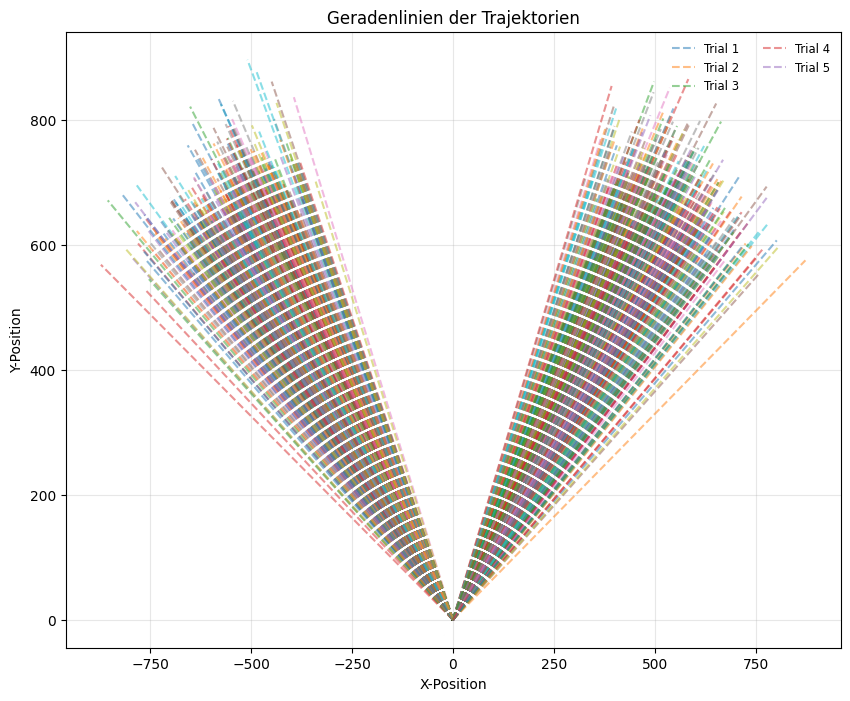

In [126]:
#nur mal um die geraden zu visualisieren
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for index, row in mirrored_df.iterrows():
    xpos = row['xpos']
    ypos = row['ypos']
    
    start = [xpos[0], ypos[0]]
    end = [xpos[-1], ypos[-1]]
    
    straight_line_x = np.linspace(start[0], end[0], len(xpos))
    straight_line_y = np.linspace(start[1], end[1], len(ypos))
    
    plt.plot(straight_line_x, straight_line_y, linestyle='--', alpha=0.5, label=f'Trial {index+1}' if index < 5 else "")

plt.title("Geradenlinien der Trajektorien")
plt.xlabel("X-Position")
plt.ylabel("Y-Position")
plt.legend(loc='upper right', fontsize='small', ncol=2, frameon=False)
plt.grid(alpha=0.3)
plt.show()
